### Hands On Machine Learning with Tensorflow 2nd Edition

In [1]:
import matplotlib.pyplot as plt
import gym
from IPython import display
import numpy as np

import tensorflow as tf
from tensorflow import keras

%matplotlib inline


In [2]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([-0.0112167 ,  0.01133902,  0.04507354, -0.03925472])

In [3]:
env.action_space

Discrete(2)

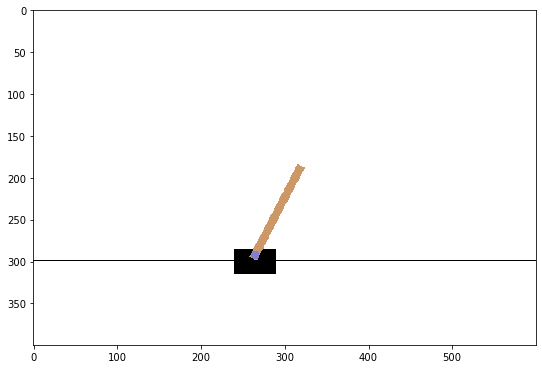

In [4]:


env = gym.make('CartPole-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # call this once

for _ in range(25):
    img.set_data(env.render(mode='rgb_array')) # update the data
    display.display(plt.gcf())    
    display.clear_output(wait=True)
    env.step(env.action_space.sample()) # take a random action

env.close()

In [18]:
def run_simulation(policy):
    totals = []
    for episode in range(500):
        episode_rewards = 0
        obs = env.reset()
        for step in range(200):
            action = policy(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        totals.append(episode_rewards)
    return totals

In [19]:
def basic_policy(obs):
    """
    takes in angle and moves left or right depending on angle
    """
    angle = obs[2]
    return 0 if angle < 0 else 1

In [20]:
totals = run_simulation(basic_policy)

In [21]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.498, 8.549970526264989, 24.0, 72.0)

In [23]:
n_inputs = 4 # env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape = [n_inputs]),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 25        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [64]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads


In [72]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [73]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discount_rewards - reward_mean) / reward_std
            for discount_rewards in all_discounted_rewards]

In [74]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [75]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [76]:
n_iterations = 150 # 
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [77]:
optimizer = keras.optimizers.Adam(lr=0.01)  # lr = learning rate
loss_fn = keras.losses.binary_crossentropy

In [80]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
    env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
        [final_reward * all_grads[episode_index][step][var_index]
         for episode_index, final_rewards in enumerate(all_final_rewards) 
         for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [89]:
for reward in all_rewards:
    print(sum(reward))

165.0
120.0
200.0
200.0
140.0
200.0
172.0
134.0
200.0
200.0


#### Q-value iteration

In [91]:
transition_probabilities = [ # shape=[s, a, s']        
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], 
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']        
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],        
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],        
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]
    

In [151]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

In [156]:
gamma = 0.90 # discount factor

q_val_array = []
for iteration in range(50):
    Q_prev  = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
    q_val_array.append(Q_values.copy())


In [157]:
Q_values

array([[18.91891892, 17.02702703, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [158]:
np.argmax(Q_values, axis=1) # optimal action for each state


array([0, 0, 1], dtype=int64)

In [159]:
print([q_val[0][0] for q_val in q_val_array])

[18.45893578215504, 18.629129542757678, 18.736351611937337, 18.803901515520522, 18.84645795477793, 18.873268511510094, 18.890159162251358, 18.900800272218355, 18.907504171497564, 18.911727628043465, 18.91438840566738, 18.916064695570448, 18.917120758209382, 18.91778607767191, 18.918205228933303, 18.91846929422798, 18.918635655363627, 18.918740462879086, 18.918806491613825, 18.918848089716708, 18.918874296521523, 18.91889080680856, 18.91890120828939, 18.918907761222314, 18.918911889570058, 18.918914490429138, 18.918916128970356, 18.918917161251326, 18.918917811588333, 18.91891822130065, 18.91891847941941, 18.918918642034228, 18.918918744481562, 18.918918809023385, 18.91891884968473, 18.91891887530138, 18.91891889143987, 18.918918901607114, 18.918918908012483, 18.918918912047864, 18.918918914590154, 18.918918916191796, 18.91891891720083, 18.91891891783652, 18.918918918237008, 18.918918918489315, 18.918918918648266, 18.918918918748407, 18.918918918811496, 18.918918918851244]


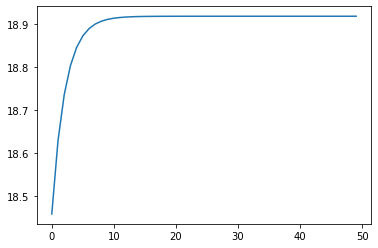

In [160]:
plt.plot(range(50), [q_val[0][0] for q_val in q_val_array])

In [152]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [153]:
def exploration_policy(state):    
    return np.random.choice(possible_actions[state])

In [161]:
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
q_val_array = []
for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
    q_val_array.append(Q_values.copy())
    

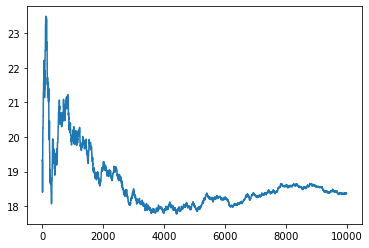

In [162]:
plt.plot(range(10000), [q_val[0][0] for q_val in q_val_array])